<a href="https://www.kaggle.com/code/daliimsadek/deeplab-unet-resnet50-breast-cancer-detection?scriptVersionId=134132563" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Dependencies 

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import shutil
from tqdm import tqdm



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Importing the Data

In [2]:
images = []
mask = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")
for i in mask:
    images.append(i.replace('_mask',''))

In [3]:
print(images[:5])
print('-------------------')
print(mask[:5])

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261).png']
-------------------
['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png']


In [4]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
5,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
6,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
7,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
8,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...


# Importing the Models : 
## DeeplabV3ResNet
## Res50Unet

this cell is mandatory to load the models 

In [5]:
def pixel_accuracy(y_true, y_pred):
    # Convert the predicted probabilities to class labels
    y_pred = tf.argmax(y_pred, axis=-1)

    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Cast y_true to the same data type as y_pred
    y_true = tf.cast(y_true, y_pred.dtype)

    # Calculate the pixel accuracy
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.cast(tf.size(y_true), tf.float32)

    accuracy = correct_pixels / total_pixels
    return accuracy


In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(K.argmax(y_true), K.shape(y_true)[-1])
    y_pred = tf.one_hot(K.argmax(y_pred), K.shape(y_pred)[-1])
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    union = K.sum(y_true, axis=[0, 1, 2]) + K.sum(y_pred, axis=[0, 1, 2])
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return K.mean(dice_coef)



def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)



def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [7]:
keras.utils.get_custom_objects()['pixel_accuracy'] = pixel_accuracy
keras.utils.get_custom_objects()['dice_coef'] = dice_coef
keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss
keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss

In [8]:
import pickle

# Load the pre-trained models using pickle
with open('/kaggle/input/deeplab/model_deeplab.pkl', 'rb') as f:
    deeplab_model = pickle.load(f)
with open('/kaggle/input/res50unet/model_v1.pkl', 'rb') as f:
    unet_model = pickle.load(f)

# Create a DataFrame That contains the predictions 

### this cell is to put the predctions of the two models into two lists 

In [9]:
predictions_unet = []
predictions_deeplab = []
for i in range(len(data.index)) : 
    img = cv2.imread(data['images'].iloc[i])
    img = cv2.resize(img ,(512, 512))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred1=unet_model.predict(img)
    pred2=deeplab_model.predict(img)
    predictions_unet.append(pred1)
    predictions_deeplab.append(pred2)

1/1 [==============================] - 0s 25ms/step


### Save the predictions to work with paths  

In [10]:

# Set the directory where you want to save the images
save_dir_unet = "/Predictionss/unet_predictions"
save_dir_deeplab = "/Predictionss/deeplab_predictions"

# If using Kaggle, set the save directories accordingly
# save_dir_unet = "../output/your_kaggle_path/unet_predictions"
# save_dir_deeplab = "../output/your_kaggle_path/deeplab_predictions"

# Create the directories if they don't exist
os.makedirs(save_dir_unet, exist_ok=True)
os.makedirs(save_dir_deeplab, exist_ok=True)

# Loop through the images and save them
for i in tqdm(range(np.array(predictions_unet).shape[0]), desc="Saving images"):
    # Preprocess the image from predictions_unet
    image_unet = np.squeeze(predictions_unet[i])  # Remove dimensions of size 1 if present
    image_unet = (image_unet * 255).astype(np.uint8)  # Convert to uint8 and scale to 0-255 range

    # Convert the preprocessed array to PIL image
    img_unet = Image.fromarray(image_unet)

    # Save the image from predictions_unet
    img_unet.save(os.path.join(save_dir_unet, f"image_unet_{i}.png"))

    # Preprocess the image from predictions_deeplab
    image_deeplab = np.squeeze(predictions_deeplab[i])  # Remove dimensions of size 1 if present
    image_deeplab = (image_deeplab * 255).astype(np.uint8)  # Convert to uint8 and scale to 0-255 range

    # Convert the preprocessed array to PIL image
    img_deeplab = Image.fromarray(image_deeplab)

    # Save the image from predictions_deeplab
    img_deeplab.save(os.path.join(save_dir_deeplab, f"image_deeplab_{i}.png"))

    


Saving images: 100%|██████████| 780/780 [00:27<00:00, 28.48it/s]


### Create a DataFrame that contains the paths of the images 

In [11]:
data_pred = pd.DataFrame({'True Masks':data['masks'],'Masks By Unet':data['masks'], 'Masks By Deeplab':data['masks']})

#### Fill the Data Frame 

In [12]:
for i in range(len(data.index)) : 
    image_path1 = f"/Predictionss/unet_predictions/image_unet_{i}.png"
    image_path2 = f"/Predictionss/deeplab_predictions/image_deeplab_{i}.png"
    data_pred['Masks By Unet'][i] =  image_path1
    data_pred['Masks By Deeplab'][i] =  image_path2


## Splitting the Data 

In [13]:
data_train,data_test=train_test_split(data_pred,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.1)

# Compare Some Predicitions 

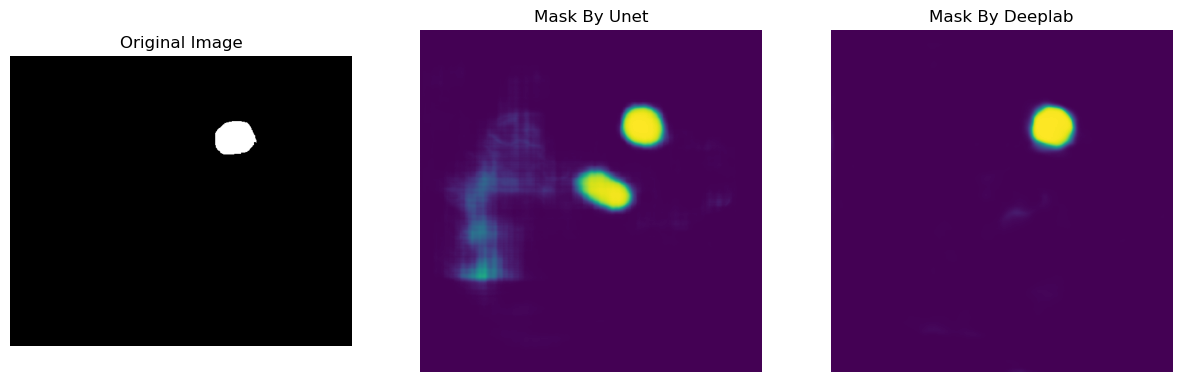

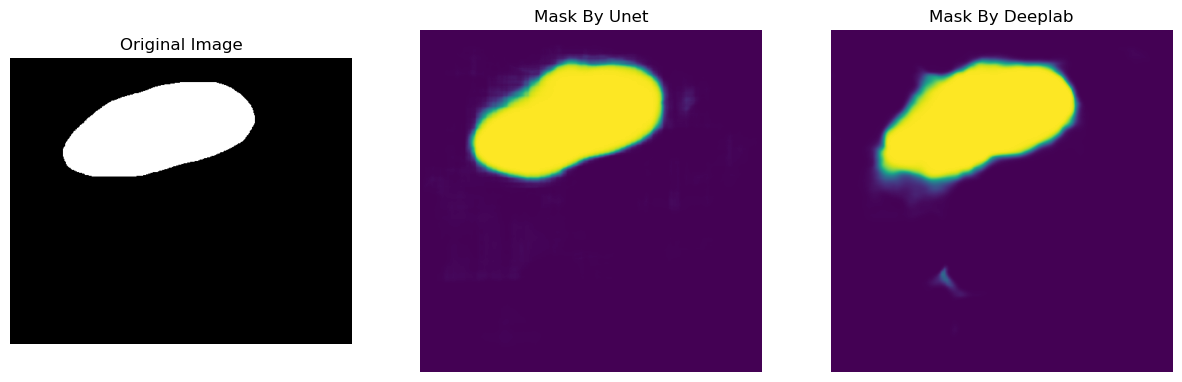

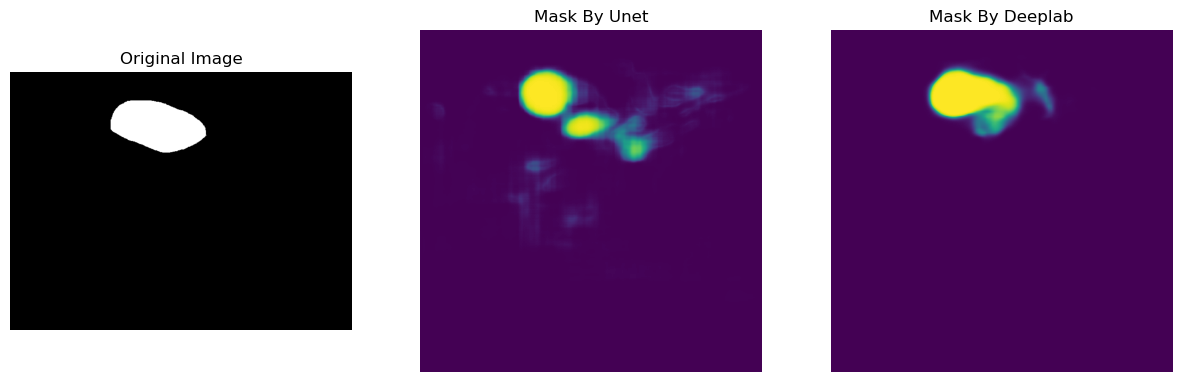

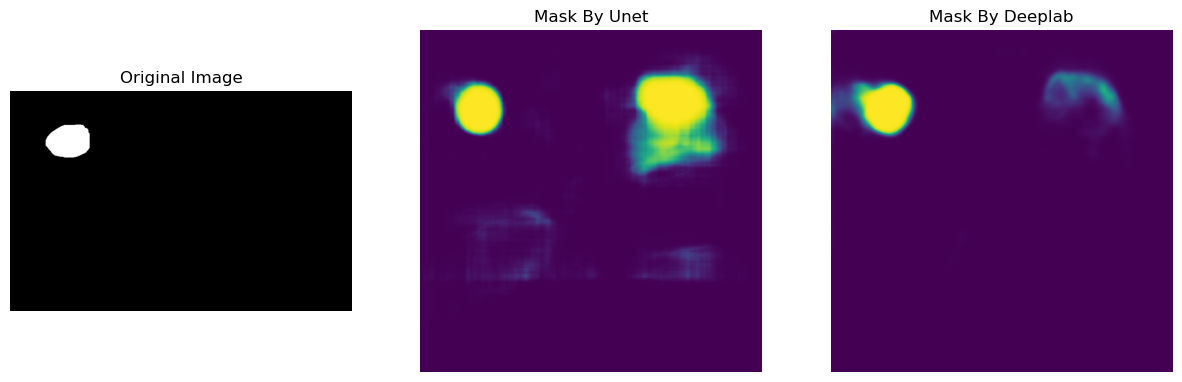

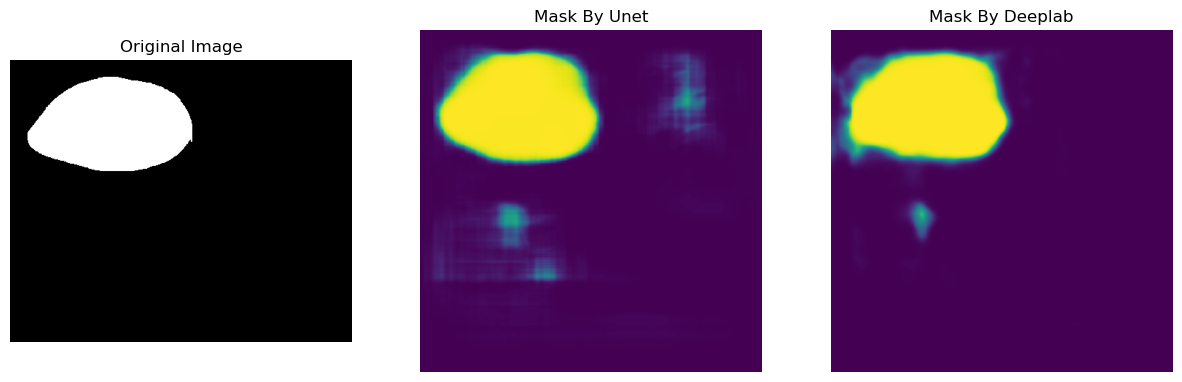

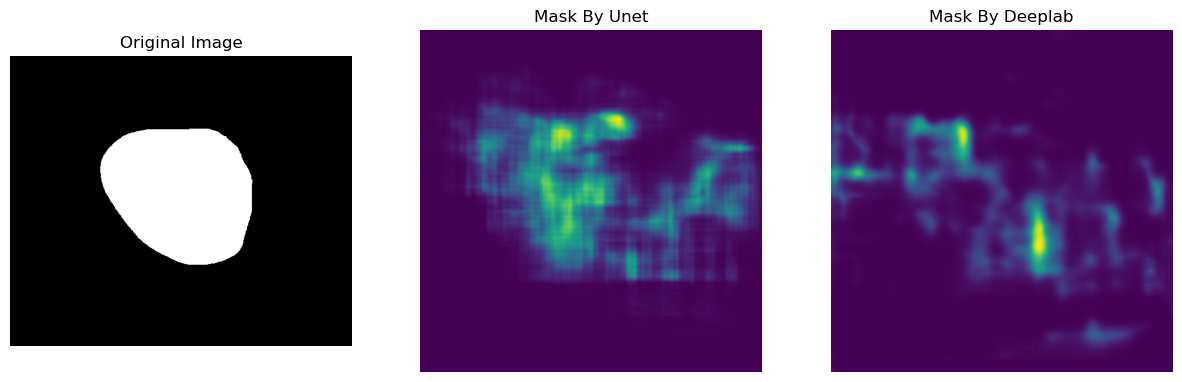

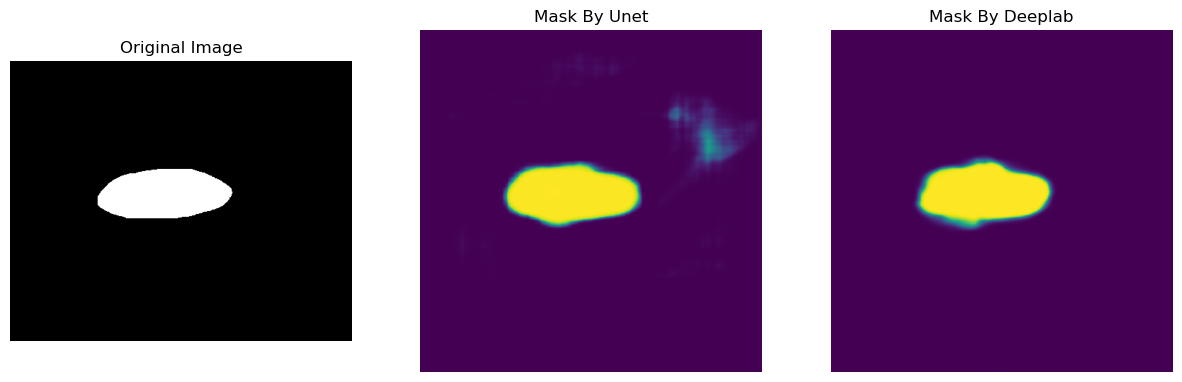

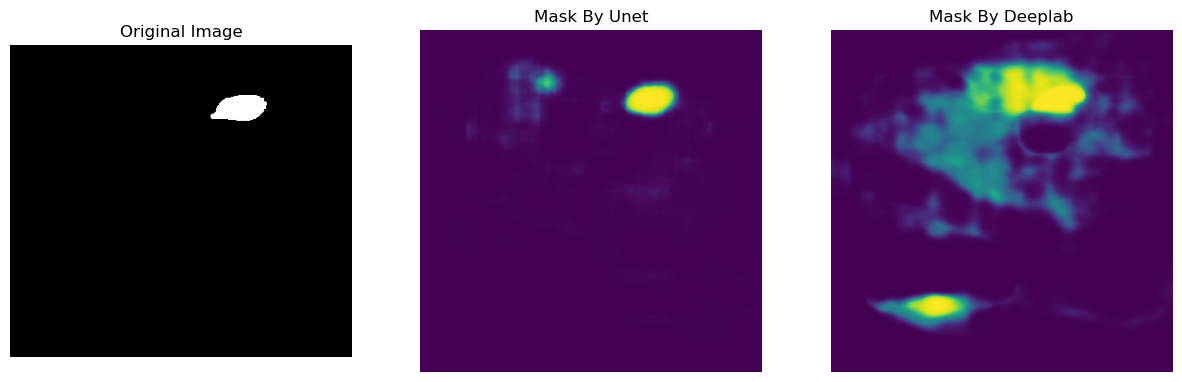

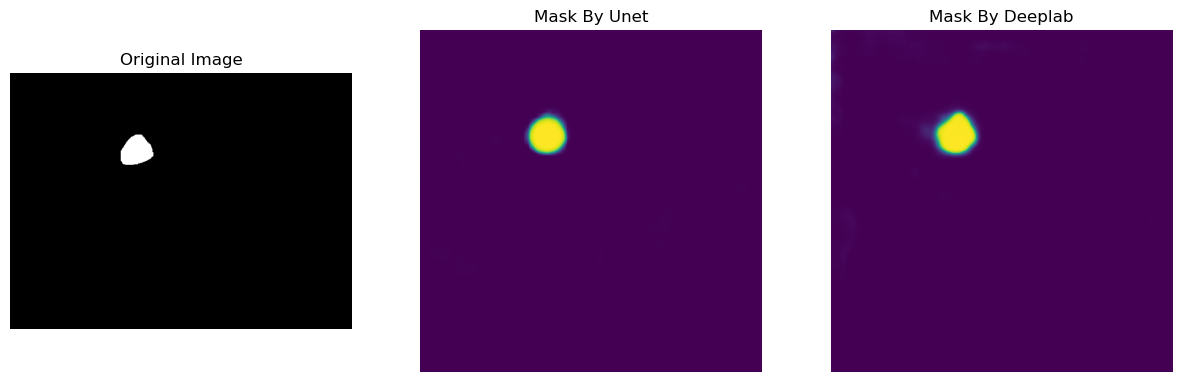

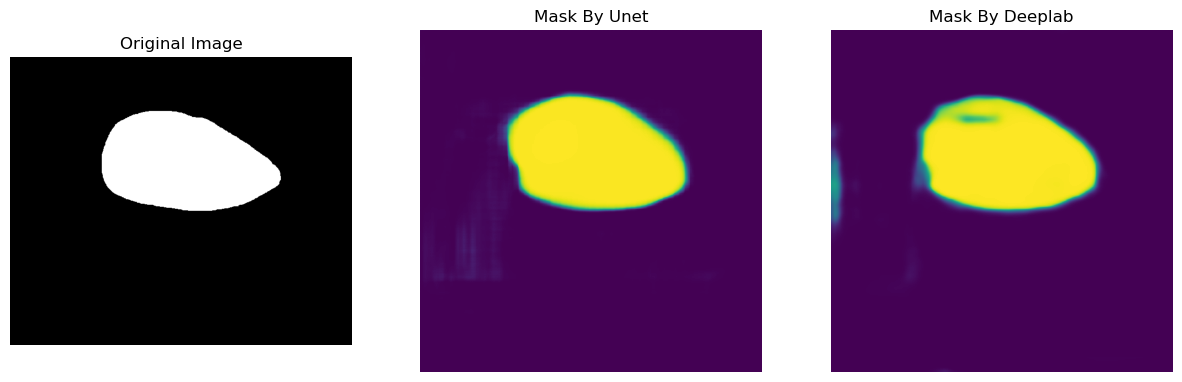

In [14]:

for i in range(10) : 
    image_path1 = f"/Predictionss/unet_predictions/image_unet_{i}.png"
    image_path2 = f"/Predictionss/deeplab_predictions/image_deeplab_{i}.png"
    image_path3 = data['masks'][i]

# Load the image using PIL
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)
    image3 = Image.open(image_path3)
# Display the image
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,2)
    plt.title('Mask By Unet')

    plt.imshow(image1)

    plt.axis('off')  # Turn off the axes
    plt.subplot(1,3,3)
    plt.title('Mask By Deeplab')

    plt.imshow(image2)
    plt.axis('off')
    # Turn off the axes
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(image3)
    plt.axis('off')  # Turn off the axes
    plt.show()


# Data Augmentation

In [15]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1./255
                            )

In [16]:
true_images_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(512,512), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="True Masks", 
                                    batch_size=8,
                                    class_mode=None
                            
                                    
)
maskunet_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(512,512), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="Masks By Unet", 
                                    batch_size=8,
                                    class_mode=None
                                    
)
maskdeeplab_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(512,512), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="Masks By Deeplab", 
                                    batch_size=8,
                                    class_mode=None
)

Found 631 validated image filenames.
Found 631 validated image filenames.
Found 631 validated image filenames.


In [17]:
true_images_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(512,512), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="True Masks", 
                                    batch_size=8,
                                    class_mode=None
)

maskunet_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(512,512), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="Masks By Unet", 
                                    batch_size=8,
                                    class_mode=None
)
maskdeeplab_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(512,512), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="Masks By Deeplab", 
                                    batch_size=8,
                                    class_mode=None
)

Found 71 validated image filenames.
Found 71 validated image filenames.
Found 71 validated image filenames.


In [18]:
train_gen = zip(maskunet_train, maskdeeplab_train,true_images_train)
valid_gen = zip(maskunet_validation, maskdeeplab_validation,true_images_validation)

# The Model 

In [19]:
def stacking_model(input_shape):
    inputs1 = tf.keras.layers.Input(shape = input_shape)  # Adjust input shape as per your image dimensions
    inputs2 = tf.keras.layers.Input(shape = input_shape)  # Adjust input shape as per your image dimensions
    
    # Model 1
    conv1_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs1)
    conv1_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1_1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)
    
    # Model 2
    conv2_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs2)
    conv2_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)
    
    # Concatenate the outputs of both models
    concat = tf.keras.layers.Concatenate()([pool1, pool2])
    
    # Additional convolutional layers
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    
    # Output layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(conv4)  # Adjust num_classes as per your segmentation task
    
    model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=output)
    
    return model


In [20]:
input_shape = (512,512,1)
num_epochs=10

In [21]:
model = stacking_model(input_shape)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy')
